# TME 1-2 - Classifieur Lineaire et non-lineaire

## Générer des données
Génération de données séparable linéairement et non séparable linéairement pour tester les algorithme des deux TME 1 et 2

In [1]:
require 'torch'
require 'nn'
require 'gnuplot'
require 'image'

function gauss(nb_pts, nb_dims, sigma, mu)
  local nb_pts = nb_pts or 20
  local nb_dims = nb_dims or 2

  local x_data=torch.randn(nb_pts, nb_dims)
  for i=1, nb_dims do
    x_data[{{}, {i}}]=x_data[{{}, {i}}]*sigma+mu[i]
  end
  return x_data
end


function generate_data(type, nb_pts, labels, sigma, mu)
  local type = type or 0

  -- generate x
  local x_data=torch.Tensor(nb_pts,#labels)
  -- mélange de 2 gaussienne
  if (type==0) then
    mus = {{-mu, -mu}, {mu, mu} }
  end
  
  -- mélange de 4 gaussienne
  if (type==1) then
    mus = {{-mu, -mu}, {mu, mu}, {-mu, mu},{mu, -mu} }
  end
  for i=1, #mus do
    l = (i-1) * (nb_pts / #mus) + 1
    k = l + (nb_pts / #mus) - 1
    g = gauss((nb_pts / #mus), #labels, sigma, mus[i])
    x_data[{{l, k}, {} }] = g
  end


  -- generate y
  local y_data=torch.Tensor(nb_pts, 1):fill(1)
  for i=1, #labels do
    a = (i-1) * (nb_pts/#labels) + 1
    b = a + (nb_pts/#labels) - 1
    y_data[{{a, b}}] = labels[i]
  end
  
  return x_data, y_data
end

## Dessin des courbes

In [2]:
-- Générer une grille 500 x 500
-- chaque point est sur deux dimensions
function grille(x,pts)
  local xmin = x:min(1)[1]
  local xmax = x:max(1)[1]
  local x1 = torch.linspace(xmin[1], xmax[1], pts)
  local x2 = torch.linspace(xmin[2], xmax[2], pts)
  local grille = torch.zeros( pts * pts, 2)
  for i=1, pts do
    for j=1, pts do
      grille[(i-1)*pts+j][1] = x1[i]
      grille[(i-1)*pts+j][2] = x2[j]
    end
  end
  return grille
end

function p(label,x, c, t)
   return {t..tostring(label), x[{{},1}], x[{{},2}], 'p ls 13 lc rgb "'..c..'"'}
end


function draw(x_data, y_data, couches, colors, bgcolors, labels, title, kernel_trick)
  
  local kernel_trick = kernel_trick or false
  local plot = {}
  -- frontière de décision
  local xGrid = grille(x_data, 500)
  if ( kernel_trick==true ) then
    xGrid = torch.cat(xGrid, torch.cmul(xGrid[{{},1}], xGrid[{{},2}]),2)
  end

  local tmpGrid = xGrid
  for i = 1, #couches-1 do
      tmpGrid = couches[i]:forward(tmpGrid)
  end
    
  local yGrid = couches[#couches]:forward(tmpGrid)
  yGrid = yGrid:sign()
  
  
  local indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
  for i = 1, #labels do
    local selected = indices[yGrid:eq(labels[i])]
    if selected:nDimension(1) > 0 then
      table.insert(plot, p(labels[i], xGrid:index(1, selected), bgcolors[i], "region "))
    end
  end

  -- points
  indices = torch.linspace(1,y_data:size(1),y_data:size(1)):long()
  for i = 1, #labels do
    local selected = indices[y_data:eq(labels[i])]
    if selected:nDimension(1) > 0 then
      table.insert(plot, p(labels[i], x_data:index(1, selected), colors[i], "classe "))
    end
  end

  -- afficher la figure
  fig = gnuplot.pngfigure(title..".png")
  gnuplot.plot(plot)
  gnuplot.close()

end

## Descente de gradient

In [3]:
function gradient_descent(x,y, criterion)
  local nb_attr = x:size(2) 
  local module = nn.Linear(nb_attr,1)
  local ITERATION = 100
  local GRADIENT_STEP = 1e-2

  for i=1, ITERATION do
    module:zeroGradParameters()
    out = module:forward(x)
    loss = criterion:forward(out, y) 
    delta = criterion:backward(out,y)
    module:backward(x, delta)
    module:updateParameters(GRADIENT_STEP)
    -- print(i, loss)
  end

  return { module }
end

## Modèle linéaire

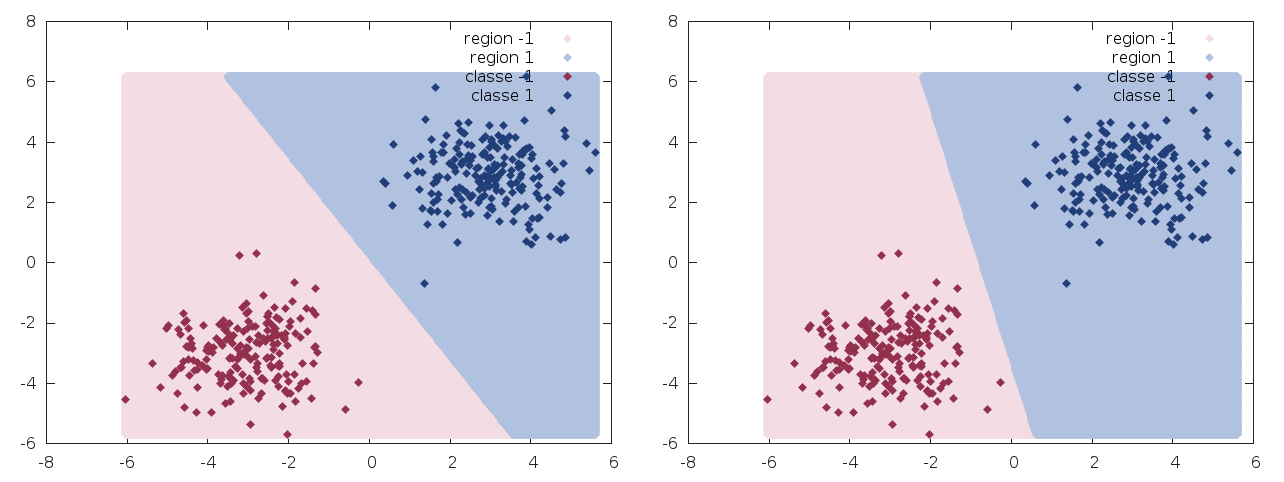

In [4]:
-- Params
local nb_pts=100*4
local labels={-1,1}
local sigma=1
local mu=3
local bgcolors = {"#F4DCE3", "#B1C1E0"}
local colors = {"#92304E", "#213E78"}
local MSECriterion = nn.MSECriterion()
local marginCriterion = nn.MarginCriterion()

local x, y = generate_data( 0, nb_pts, labels, sigma, mu)

-- linéaire + MSE
local model = gradient_descent(x,y, MSECriterion) 
draw(x, y, model, colors, bgcolors, labels, "linear-MSE")

-- linéaire + Margin
local model = gradient_descent(x,y, marginCriterion) 
draw(x, y, model, colors, bgcolors, labels, "linear-margin")

itorch.image( { image.load( 'linear-MSE.png'), image.load('linear-margin.png')} )

## Modèle non linéaire

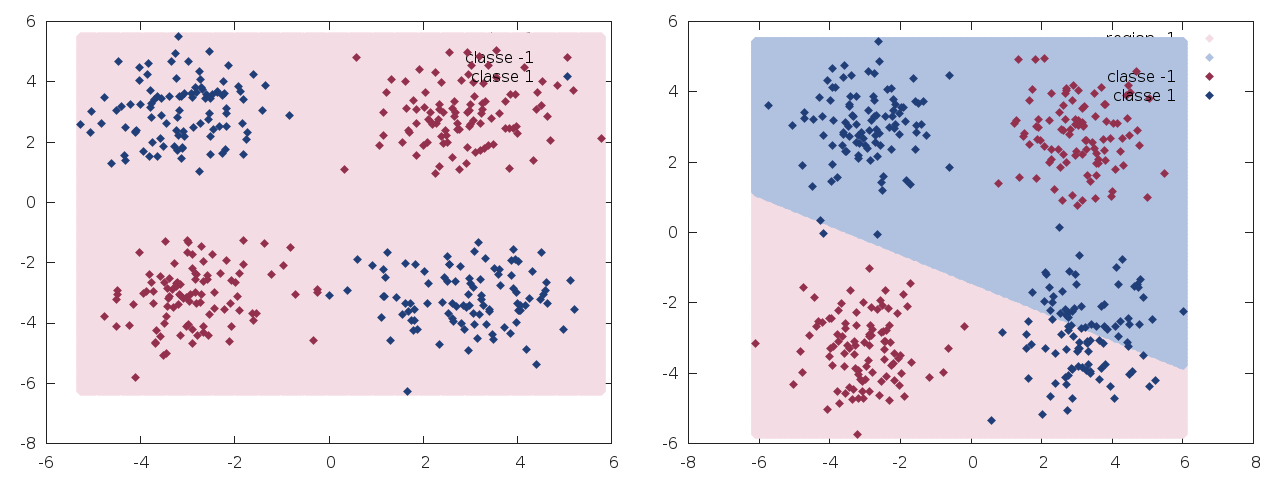

In [16]:
-- Params
local nb_pts=100*4
local labels={-1,1}
local sigma=1
local mu=3
local bgcolors = {"#F4DCE3", "#B1C1E0"}
local colors = {"#92304E", "#213E78"}
local MSECriterion = nn.MSECriterion()
local marginCriterion = nn.MarginCriterion()

local x, y = generate_data( 1, nb_pts, labels, sigma, mu)

-- Non-linéaire + MSE
local model = gradient_descent(x,y, MSECriterion) 
draw(x, y, model, colors, bgcolors, labels, "non-linear-MSE")

-- Non-linéaire + Margin
local x, y = generate_data( 1, nb_pts, labels, sigma, mu)
local model = gradient_descent(x,y, marginCriterion) 
draw(x, y, model, colors, bgcolors, labels, "non-linear-Margin")

itorch.image( { image.load( 'non-linear-MSE.png'), image.load('non-linear-Margin.png')} )

## Kernel-Trick

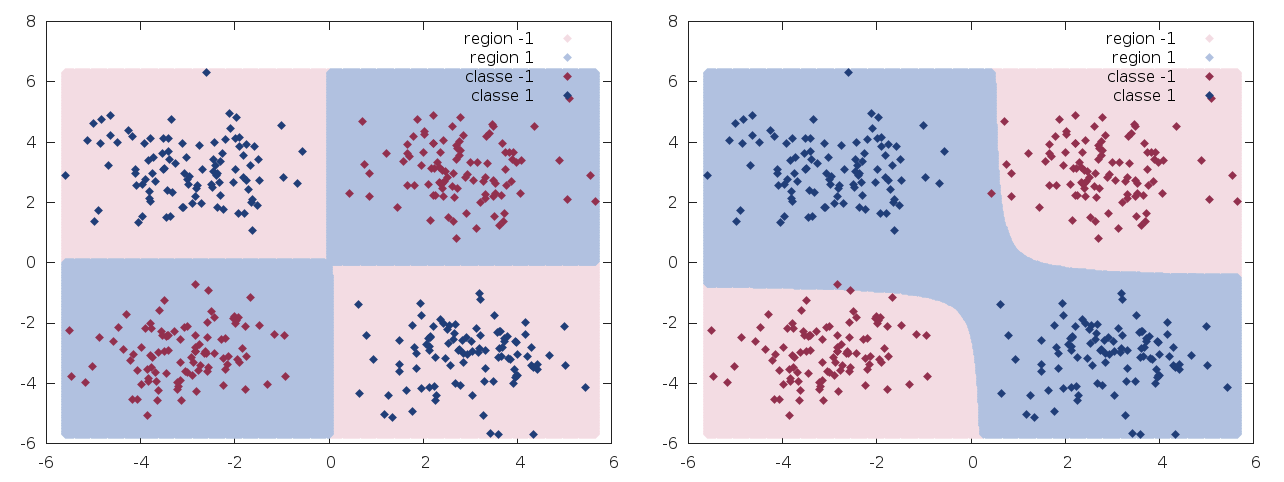

In [47]:
-- Params
local nb_pts=100*4
local labels={-1,1}
local sigma=1
local mu=3
local bgcolors = {"#F4DCE3", "#B1C1E0"}
local colors = {"#92304E", "#213E78"}
local MSECriterion = nn.MSECriterion()
local marginCriterion = nn.MarginCriterion()

local x, y = generate_data( 1, nb_pts, labels, sigma, mu)
x_kernel = torch.cat(x, torch.cmul(x[{{},1}],x[{{},2}]),2)

-- Non-linéaire + MSE + kernel trick
local model = gradient_descent(x_kernel,y, MSECriterion) 
draw(x, y, {model}, colors, bgcolors, labels, "non-linear-mse-kernel-trick", true)

-- Non-linéaire + Margin + kernel trick
local model = gradient_descent(x_kernel,y, marginCriterion) 
draw(x, y, {model}, colors, bgcolors, labels, "non-linear-margin-kernel-trick", true)

itorch.image( { image.load( 'non-linear-mse-kernel-trick.png'), image.load('non-linear-margin-kernel-trick.png')} )

## Modèle 3 couches

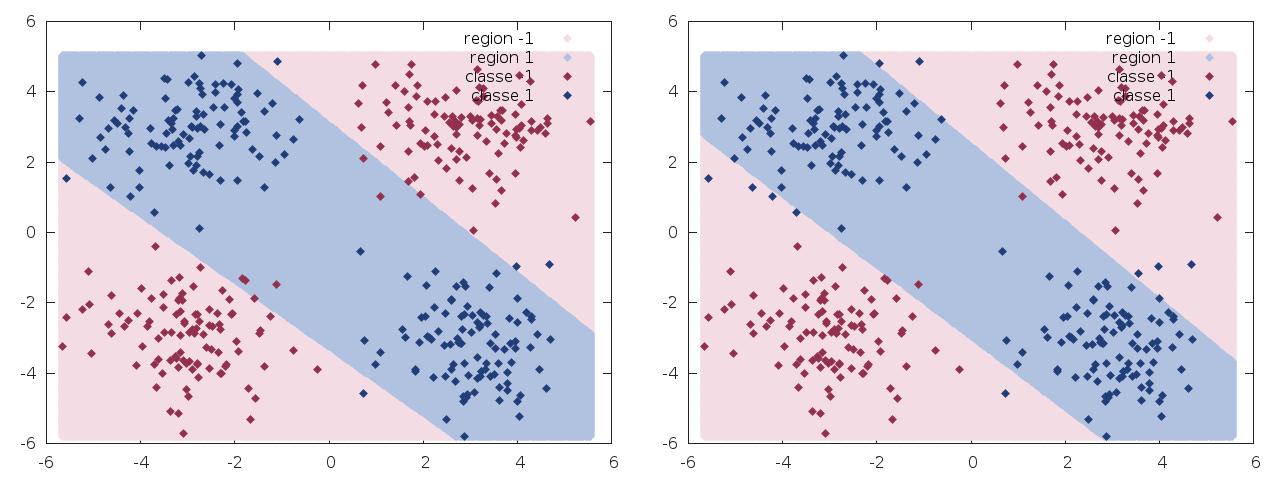

In [67]:
-- Modèle non linéaire 3 couches
-- R² -> R³ -> R
local nb_pts=100*4
local labels={-1,1}
local sigma=1
local mu=3
local bgcolors = {"#F4DCE3", "#B1C1E0"}
local colors = {"#92304E", "#213E78"}

local x, y = generate_data( 1, nb_pts, labels, sigma, mu)
local MSECriterion = nn.MSECriterion()
local MarginCriterion = nn.MarginCriterion()

local learning_rate =  1e-2
local nb_iter = 1e5

function neural_net(x,y,criterion)     
    local couche1 = nn.Linear(2, 2)
    local couche2 = nn.Tanh()
    local couche3 = nn.Linear(2, 1)

    for i=0, nb_iter do
      couche1:zeroGradParameters()
      couche2:zeroGradParameters()

      fo1 = couche1:forward(x)
      fo2 = couche2:forward(fo1)
      fo3 = couche3:forward(fo2)
      loss = criterion:forward(fo3, y)

      bo3 = criterion:backward(fo3, y)
      bo2 = couche3:backward(fo2, bo3)
      bo1 = couche2:backward(fo1, bo2)
      bo0 = couche1:backward(x, bo1)

      couche1:updateParameters(learning_rate)
      couche3:updateParameters(learning_rate)
    end
    
    return {couche1, couche2, couche3}
end

-- 3 couches - MSECriterion
local model = neural_net(x,y,MSECriterion)
draw(x, y, model, colors, bgcolors, labels, "modele-3-couches-MSE", false)

-- 3 couches - MarginCriterion
local model = neural_net(x,y,MarginCriterion)
draw(x, y, model, colors, bgcolors, labels, "modele-3-couches-margin", false)

itorch.image( { image.load("modele-3-couches-MSE.png"), image.load("modele-3-couches-margin.png")} )


## conclusion

Nous avions dans le premier TME utilisé la descente de gradient sur un modèle linéaire afin de séparer des données linéairement séparable et celà s'est avéré efficace, mais des qu'il s'agit de données non linéairement séparable ( exemple XOR ) ce modèle échoue. Du coup, nous avons utilisé une technique appellé <i>kernel-trick</i> ou il s'agit de créer une troisième feature à partir des deux première, grace à la projection $k(x): \rm I\!R^2 \rightarrow \rm I\!R^3$ tel que $ k(x1, x2) = (x1, x2, x1 * x2)$.

Dans le deuxième TME, nous avion implémenté un modèle non linéaire: Un réseau de neurones à trois couches pour résoudre le problème XOR et les résultats etait tout aussi satisfaisant.